# Анализ оттока клиентов

**Материалы:**
- [Презентация](https://disk.yandex.ru/d/VlqtxXUJnlgFYA)
- [Дашборд] (в процессе)

**Цель:** проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны к уходу из банка.

**Задачи:**
- Провести исследовательский анализ данных, определить все значимые признаки оттока клиентов;
- Сформулировать и проверить статистические гипотезы;
- Сформировать сегменты, отобрать из них лучшие и дать по ним рекомандации.

**Описание данных:**
Датасет содержит в себе данные о клиентах банка "Метанпром". Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

- **userid** - идентификатор пользователя;
- **score** - баллы кредитного скоринга;
- **City** - город;
- **Gender** - пол;
- **Age** - возраст;
- **Equity** - количество объектов в собственности / количество баллов собственности;
- **Balance** - баланс на счете;
- **Products** - количество продуктов, которыми пользуется клиент;
- **Creditcard** - наличие кредитной карты;
- **last_activity** - активный клиент;
- **estimated_salary** - заработная плата клиента;
- **Churn** - ушёл или нет.

In [1]:
#загрузим стандартные библиотеки, которые могут понадобится для работы с данными и дальнейшим анализом

import pandas as pd
import numpy as np
from numpy import median
from scipy import stats as st
import math as mth
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка и изучение данных

In [2]:
try:
    data = pd.read_csv('bank_scrooge.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

data.shape
data

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


Всего в данных 1000 строк (количество клиентов) и 12 столбцов (параметры).

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
data['score'] = data ['score'].astype(int)

Данные почти полные, заисключением двух столбцов: возраст и баланс. На этапе предобработки данных нужно будет привести название столбцов в нижний регистр, изменить тип данных некоторых столбцов.

In [5]:
data.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Возрастная категория клинетов банка - от 18 до 86 лет, количество баллов в собственности от 0 до 9, максимальное количество продуктов у клиентов - 5. Видим, что минимальное количество продуктов у клиентов - 0, либо это ошибка, либо клиент ушел из банка. Столбцы сredit_сard, last_activity, churn содержат значения 0 и 1.

In [6]:
data[data['products']==0]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
8957,147837,962,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Эту строку можно удалить, так необходимо проанализировать данные на момент, когда клиенты еще пользовались продуктами банка.

In [7]:
data = data[data['products']!=0]
data.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,9999.000000,9999.000000,9973.000000,9999.000000,7.705000e+03,9999.000000,9999.000000,9999.000000,9.999000e+03,9999.000000
mean,171817.110611,848.688069,42.730773,2.627563,8.277943e+05,1.870287,0.680468,0.523552,1.478792e+05,0.181918
std,33709.070798,65.441981,12.175166,1.980931,1.980614e+06,0.792466,0.466319,0.499470,1.393901e+05,0.385796
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142809.500000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525212e+04,0.000000
50%,172740.000000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196615e+05,0.000000
75%,201262.500000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745011e+05,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


**Вывод:**
- средний скорринговый балл: 849;
- средний возраст клиентов составляет 43 года, самому молодому клиенту 18 лет, а старшему 86;
- средний балл собственности составояет примерно 3, а максимальные 9;
- максимальное число продуктов - 5, в среднем у клиентов банка 1-2 продукта;
- большая часть клиентов имеет кредитную карту;
- половина клиентной проявляли активность в течение 30 дней.

# Предобработка данных

In [8]:
#приведем название столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [9]:
#посмотрим на наличие пропусков
data.isna().sum()

userid              0
score               0
city                0
gender              0
age                26
equity              0
balance          2294
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [10]:
#проверим наличие явных дубликатов
data.duplicated().sum()

0

In [11]:
#проверим наличие неявных дубликатов
data.duplicated(subset=['userid', 'city']).sum()

0

In [12]:
data['userid'].duplicated().sum()

73

При анализе дибликатов в столбце 'userid' было выявлено 73 повторения, но  так как банки находится в 3 городах, а при вывода дибликатов по столбцам 'userid' и 'city', они не были обнаружены, можно сделать вывод о том, что либо этот клиенты из разных городов, либо это одни и те же люди, просто открывали продукты в разных городах.

Как мы заметили ранее, в столбцах "возраст" и "баланс" есть пропуски, но пока нет смысла что-то с ними делать, кроме как заменить пропуски в столбце "баланс" на 0, возможно, в процессе исследования придется от них избавиться, чтобы не искажать результаты анализа. Явыне и неявные дубликаты необнаружены.

Посмотрим, как пропуски в столбцах зависят от остальных данных.

In [13]:
# Функция для просмотра взаимосвязей
for i in ['city', 'gender', 'products', 'credit_card', 'last_activity', 'churn']:
    print(data.groupby(i)['age'].apply(lambda x: x.isna().sum()))
    print('_____________________')


city
Ростов        1
Рыбинск      12
Ярославль    13
Name: age, dtype: int64
_____________________
gender
Ж    12
М    14
Name: age, dtype: int64
_____________________
products
1    18
2     7
3     1
4     0
5     0
Name: age, dtype: int64
_____________________
credit_card
0     6
1    20
Name: age, dtype: int64
_____________________
last_activity
0     6
1    20
Name: age, dtype: int64
_____________________
churn
0    25
1     1
Name: age, dtype: int64
_____________________


Всего пропусков по возрасты - 26, 25 из которых оставшиеся клиенты, в основном не из Ростова, возможно, это либо неправильно заполеннные анкеты клиентов, либо сбор в данных, но в любом случаей пропуски меньше 1%, поэтому анализ они не будут искажать.

Теперь посмотрим, есть ли какие-то взаимосвязи с пропусками в столбце баланса.

In [14]:
for i in ['city', 'gender', 'products', 'credit_card', 'last_activity', 'churn']:
    print(data.groupby(i)['balance'].apply(lambda x: x.isna().sum()))
    print('_____________________')

city
Ростов        235
Рыбинск       592
Ярославль    1467
Name: balance, dtype: int64
_____________________
gender
Ж    1012
М    1282
Name: balance, dtype: int64
_____________________
products
1    1950
2     315
3      29
4       0
5       0
Name: balance, dtype: int64
_____________________
credit_card
0     422
1    1872
Name: balance, dtype: int64
_____________________
last_activity
0    1033
1    1261
Name: balance, dtype: int64
_____________________
churn
0    2282
1      12
Name: balance, dtype: int64
_____________________


Всего пропусков в столбце баланса было выявлено 2294, что составляет 23% от всех данных. Больше всего пропусков у клиентов из города Ярославль, с одним продуктом, кредитной картой, которые не собираются уходить, возможно, что опять это проблемы при выгрузке данных, либо они скрыты по определенным причинам, но в любом случае почти четверть данных не целесообрано удалять, поэтому можно их занулить.

In [15]:
data['balance'] = data['balance'].fillna(0)
data.isna().sum()

/tmp/ipykernel_128/2662117181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['balance'] = data['balance'].fillna(0)


userid            0
score             0
city              0
gender            0
age              26
equity            0
balance           0
products          0
credit_card       0
last_activity     0
est_salary        0
churn             0
dtype: int64

In [16]:
#посмотрим на уникальные значения столбца city
data['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

Итак, у нас есть три города: Рыбинск, Ярославль и Ростов Великий.

In [17]:
#закодируем значения нескольких столбцов

#созданим копию столбов 
data['city_copy']=data['city']
data['gender_copy']=data['gender']

data = pd.get_dummies(data, columns=['city_copy', 'gender_copy'])

data.head()

/tmp/ipykernel_128/576170672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['city_copy']=data['city']
/tmp/ipykernel_128/576170672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gender_copy']=data['gender']


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_copy_Ростов,city_copy_Рыбинск,city_copy_Ярославль,gender_copy_Ж,gender_copy_М
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30.0,0,0.00,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


In [18]:
data = data.rename(columns = ({'city_copy_Ростов':'city_Rostov', 'city_copy_Рыбинск':'city_Rybinsk','city_copy_Ярославль':'city_Yaroslavl', 'gender_copy_Ж':'female', 'gender_copy_М':'male'}))
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Rostov,city_Rybinsk,city_Yaroslavl,female,male
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30.0,0,0.00,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


**Вывод:**

- к нижнему регистру были приведены все названия столбцов;
- явных дубликатов не было обнаружено, но среди неявных было получено 73 дибликата по стообце номера пользователя, но при выводе дубликатов не только по номеру пользователя, но и по городу, было определено их отстутствие, соотсветвенно, можно сделать вывод, что это какой-то сбой при заполнения анкет клиентов, возможно люди просто из разных городов, но с одинаковым ФИО и возрастом;
- пропуски были обнаружены в двух столбцах: возраст и баланс, но никаких закономерностей не было обнаружено, удалять строки не целесообразно, потому что проспуски в столбце возраст составляли менее 1%, что не повлияет на анализ, а в столюбце баланс почти четверь, что могло бы сильно исказить результат анализа.
- для дальнейшего исследования, были закодированы 2 столбца "пол" и "город".


# Исследовательский анализ данных

**Необходимо провести анализ оттока клинетов в разрезе всех параметров**

Для каждого из параметровм рассчитаем сумму, количество и процент оттока клинетов, создавая сводные таблицы, построим визуализацию и сформулируем выводы. 

Посчитаем средний уровень оттока, котой в дальнейшем отобразим на графиках.

In [19]:
for column in ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn']:
    churn_rate = int((data.query('churn == 1').groupby(column).agg({'churn':'count'})).mean())/100

In [20]:
print (churn_rate, '%')

18.19 %


Параметр_1: **score** - скоринговый балл отточного клиента.

In [21]:
score_churn = data.pivot_table (index = 'score', values = 'churn', aggfunc =['sum', 'count'])
score_churn.columns = score_churn.columns.droplevel(level=1)
score_churn ['perc'] = score_churn['sum']/score_churn['count']*100
score_churn = score_churn [score_churn['sum']==1]
score_churn

,sum,count,perc
score,,,
706,1,11,9.090909
707,1,6,16.666667
727,1,12,8.333333
728,1,9,11.111111
730,1,8,12.500000
733,1,14,7.142857
736,1,8,12.500000
737,1,13,7.692308
739,1,15,6.666667


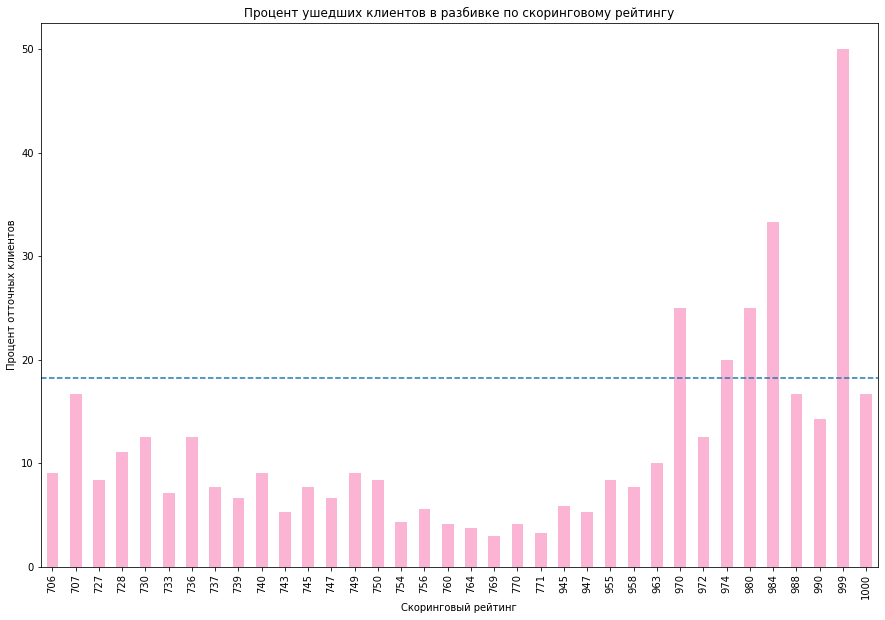

In [22]:
score_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#fcb4d5')
plt.title ('Процент ушедших клиентов в разбивке по скоринговому рейтингу')
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Скоринговый рейтинг')
plt.ylabel ('Процент отточных клиентов')
plt.show()

Выводы:
- из банка уходили клиенты, чей рейтинг 706 и выше;
- клиенты с рентингом ниже 970 уходили реже, чем с рейтингом выше;
- наиболее выйсок процент ухода клиента из банка - 999.

Параметр_2: **city** - город.

In [23]:
city_churn = data.pivot_table (index = 'city', values = 'churn', aggfunc =['sum', 'count'])
city_churn.columns = city_churn.columns.droplevel(level=1)
city_churn ['perc'] = city_churn['sum']/city_churn['count']*100
city_churn

,sum,count,perc
city,,,
Ростов,266,1417,18.772054
Рыбинск,436,2694,16.184113
Ярославль,1117,5888,18.970788


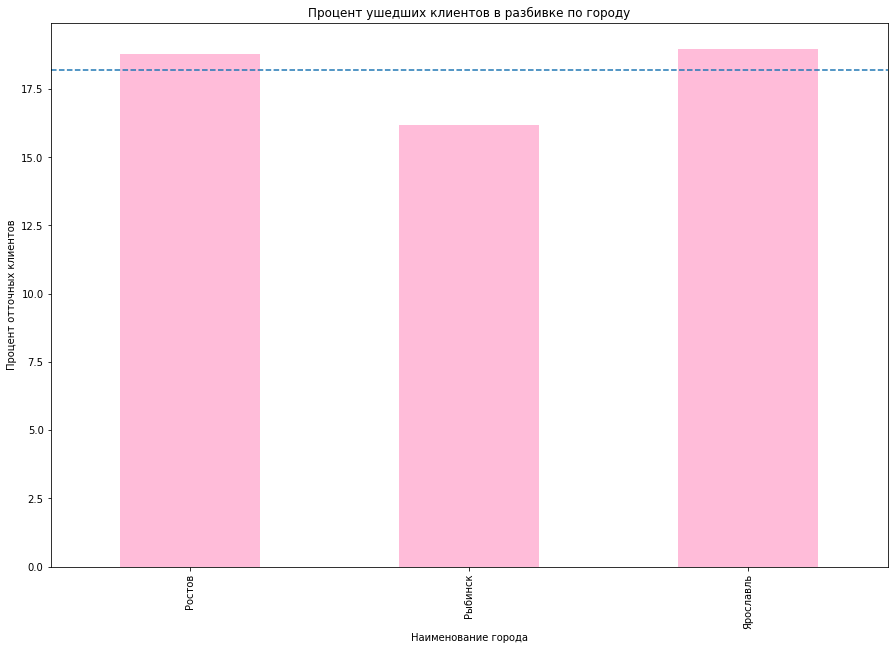

In [24]:
city_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#ffbcd9')
plt.title ('Процент ушедших клиентов в разбивке по городу')
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Наименование города')
plt.ylabel ('Процент отточных клиентов')
plt.show()

Вывод: разницы особой не наблюдается, поэтому при составлении портрета уходящего клиента, город можно не учитывать.

Параметр_3: **gender** - пол клиента.

In [25]:
gender_churn = data.pivot_table (index = 'gender', values = 'churn', aggfunc =['sum', 'count'])
gender_churn.columns = gender_churn.columns.droplevel(level=1)
gender_churn ['perc'] = gender_churn['sum']/gender_churn['count']*100
gender_churn

,sum,count,perc
gender,,,
Ж,636,4994,12.735282
М,1183,5005,23.636364


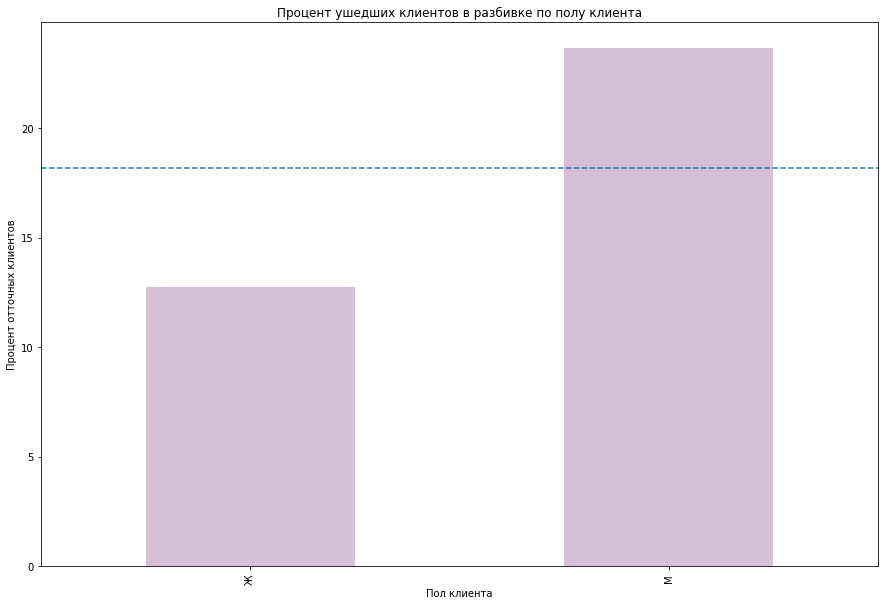

In [26]:
gender_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#d8bfd8')
plt.title ('Процент ушедших клиентов в разбивке по полу клиента')
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Пол клиента')
plt.ylabel ('Процент отточных клиентов')
plt.show()

Вывод: отточных клиентов мужского пола почти в 2 раза больше, чем женского пола.

Параметр_4: **age** - возраст клиента.

In [27]:
data['age'] = data ['age'].round(0)
age_churn = data.pivot_table (index = 'age', values = 'churn', aggfunc =['sum', 'count'])
age_churn.columns = age_churn.columns.droplevel(level=1)
age_churn ['perc'] = age_churn['sum']/age_churn['count']*100
age_churn

,sum,count,perc
age,,,
18.0,1,13,7.692308
19.0,1,16,6.250000
20.0,3,23,13.043478
21.0,4,15,26.666667
22.0,4,27,14.814815
...,...,...,...
81.0,0,4,0.000000
82.0,0,2,0.000000
83.0,0,3,0.000000


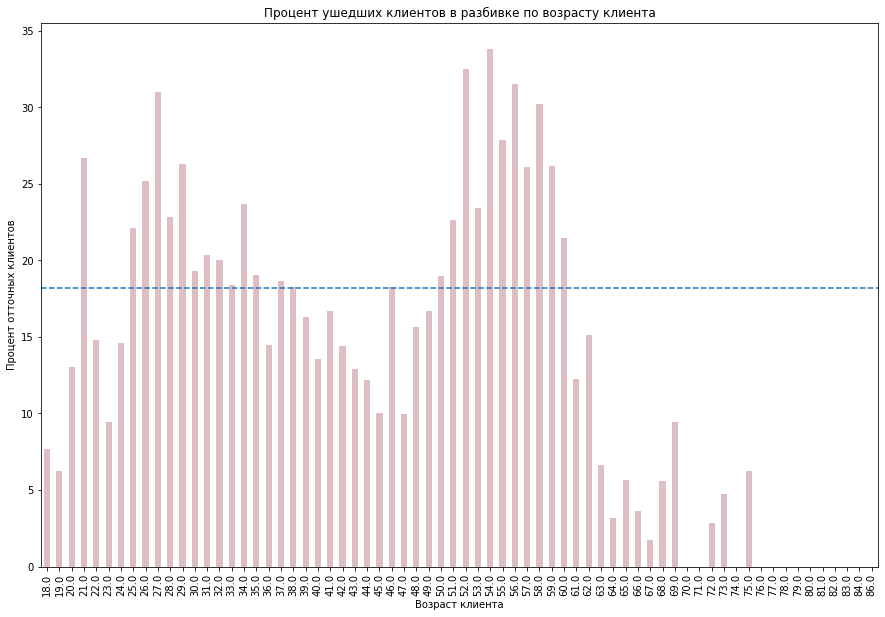

In [28]:
age_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#ddbec3')
plt.title ('Процент ушедших клиентов в разбивке по возрасту клиента') 
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Возраст клиента')
plt.ylabel ('Процент отточных клиентов')
plt.show ()

Для составления портетов уходящих клиентов, можно дополнительно создать возрастные группы и закодировать их.

In [29]:
def age_group(age):
    if 25 >= age >= 18:
        return '18-25'
    if 45 >= age >= 26:
        return '26-45'
    if 62 >= age >= 46:
        return '46-62'
    if 63 <= age:
        return '63+'
    
#добавим новый стаолбец с возрастными категориями
data['age_group'] = data['age'].apply(age_group)
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Rostov,city_Rybinsk,city_Yaroslavl,female,male,age_group
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,18-25
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,26-45
2,120722,892,Рыбинск,Ж,30.0,0,0.00,1,1,1,107683.34,0,0,1,0,1,0,26-45
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,46-62
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,26-45


In [30]:
# также созданим копию столбца "age_group" и закодируем данные
data['age_group_2']=data['age_group']
data = pd.get_dummies(data, columns = ['age_group_2'])
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,...,city_Rostov,city_Rybinsk,city_Yaroslavl,female,male,age_group,age_group_2_18-25,age_group_2_26-45,age_group_2_46-62,age_group_2_63+
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,...,0,1,0,1,0,18-25,1,0,0,0
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,...,0,1,0,1,0,26-45,0,1,0,0
2,120722,892,Рыбинск,Ж,30.0,0,0.00,1,1,1,...,0,1,0,1,0,26-45,0,1,0,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,...,0,0,1,1,0,46-62,0,0,1,0
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,...,0,0,1,0,1,26-45,0,1,0,0


In [31]:
data = data.rename (columns = ({'age_group_2_18-25':'18-25', 'age_group_2_26-45':'26-45','age_group_2_46-62':'46-62', 'age_group_2_63+':'63+'}))
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,...,city_Rostov,city_Rybinsk,city_Yaroslavl,female,male,age_group,18-25,26-45,46-62,63+
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,...,0,1,0,1,0,18-25,1,0,0,0
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,...,0,1,0,1,0,26-45,0,1,0,0
2,120722,892,Рыбинск,Ж,30.0,0,0.00,1,1,1,...,0,1,0,1,0,26-45,0,1,0,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,...,0,0,1,1,0,46-62,0,0,1,0
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,...,0,0,1,0,1,26-45,0,1,0,0


In [32]:
age_churn = data.pivot_table (index = 'age_group', values = 'churn', aggfunc =['sum', 'count'])
age_churn.columns = age_churn.columns.droplevel(level=1)
age_churn ['perc'] = age_churn['sum']/age_churn['count']*100
age_churn

,sum,count,perc
age_group,,,
18-25,62,376,16.489362
26-45,1111,6074,18.291077
46-62,613,2744,22.339650
63+,32,779,4.107831


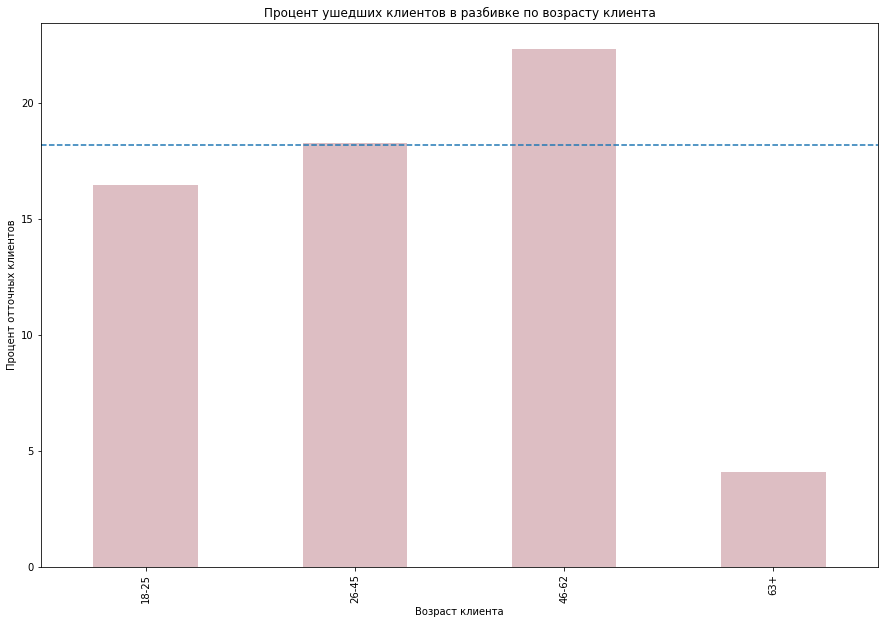

In [33]:
age_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#ddbec3')
plt.title ('Процент ушедших клиентов в разбивке по возрасту клиента') 
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Возраст клиента')
plt.ylabel ('Процент отточных клиентов')
plt.show ()

Вывод:
- больше 20% отточных клиентов относятся к возрастной категории 46-62;
- чуть меньше 20% у категории 26-45;
- меньше всего у категории 63+.

Параметр_5: **equity** - количества баллов в собственности.

In [34]:
equity_churn = data.pivot_table (index = 'equity', values = 'churn', aggfunc =['sum', 'count'])
equity_churn.columns = equity_churn.columns.droplevel(level=1)
equity_churn ['perc'] = equity_churn['sum']/equity_churn['count']*100
equity_churn

,sum,count,perc
equity,,,
0,90,2592,3.472222
1,93,774,12.015504
2,166,1052,15.779468
3,321,1542,20.817121
4,464,1850,25.081081
5,577,1918,30.083420
6,58,161,36.024845
7,37,80,46.250000
8,6,17,35.294118


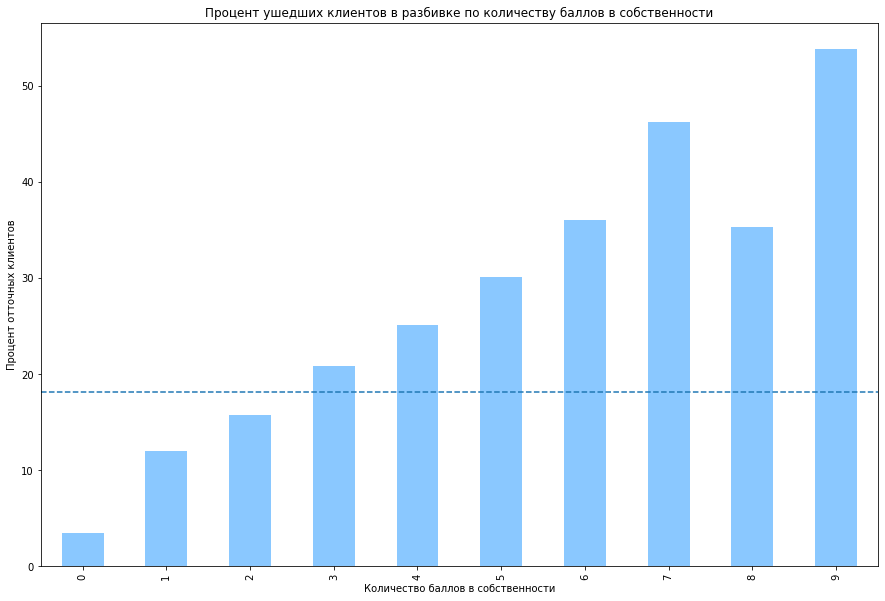

In [35]:
equity_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#8ac8ff')
plt.title ('Процент ушедших клиентов в разбивке по количеству баллов в собственности') 
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Количество баллов в собственности')
plt.ylabel ('Процент отточных клиентов')
plt.show ()

Вывод: чем выше оценка стоимости собственности, тем выше процент оттока клиентов.

Параметр_6: **products** - количества баллов в собственности.

In [36]:
products_churn = data.pivot_table (index = 'products', values = 'churn', aggfunc =['sum', 'count'])
products_churn.columns = products_churn.columns.droplevel(level=1)
products_churn ['perc'] = products_churn['sum']/products_churn['count']*100
products_churn

,sum,count,perc
products,,,
1,235,3341,7.033822
2,979,5126,19.098712
3,297,1039,28.585178
4,300,474,63.291139
5,8,19,42.105263


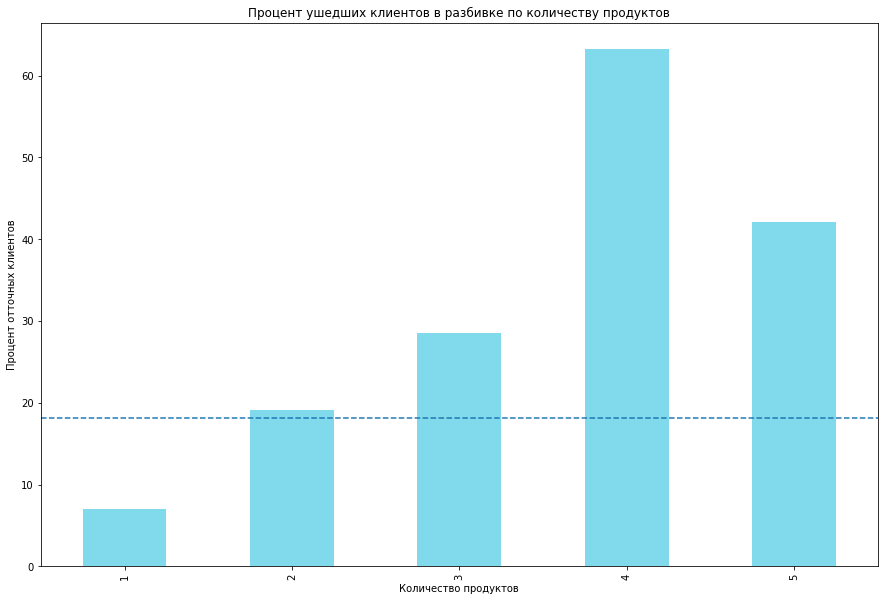

In [37]:
products_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#80daeb')
plt.title ('Процент ушедших клиентов в разбивке по количеству продуктов') 
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Количество продуктов')
plt.ylabel ('Процент отточных клиентов')
plt.show ()

Вывод:
-  больше 60% оттока клиентов, у которых было 4 продукта;
- чуть больше 40% у клиентов с 5 продуктами;
- меньше всего отток вреди клиентов, у которых 1-2 продукта.

Параметр_7: **credit_card** - наличие кредитной карты.

In [38]:
credit_card_churn = data.pivot_table (index = 'credit_card', values = 'churn', aggfunc =['sum', 'count'])
credit_card_churn.columns = credit_card_churn.columns.droplevel(level=1)
credit_card_churn ['perc'] = credit_card_churn['sum']/credit_card_churn['count']*100
credit_card_churn

,sum,count,perc
credit_card,,,
0,816,3195,25.539906
1,1003,6804,14.741329


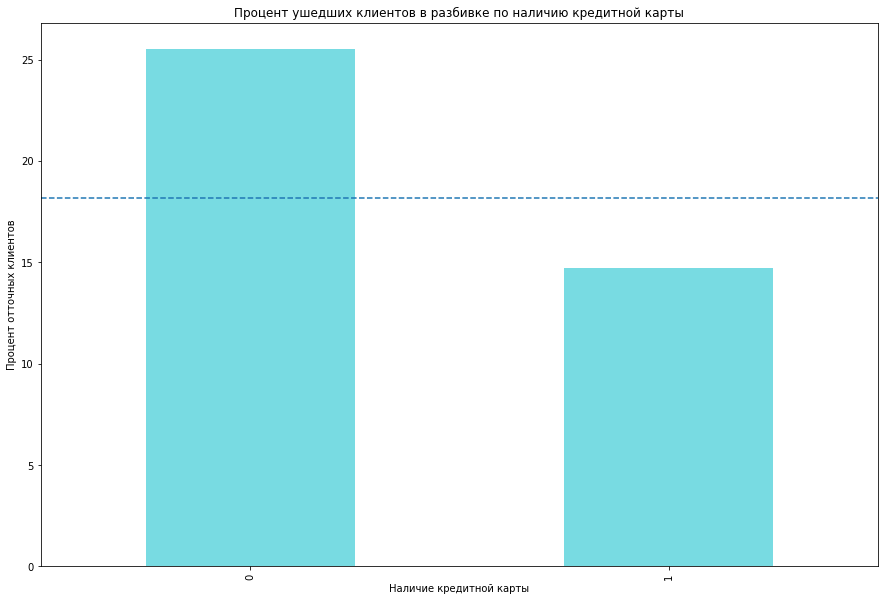

In [39]:
credit_card_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#78dbe2')
plt.title ('Процент ушедших клиентов в разбивке по наличию кредитной карты') 
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Наличие кредитной карты')
plt.ylabel ('Процент отточных клиентов')
plt.show ()

Вывод: клиенты, у которых не была открыта кредитная карта, уходили почти в 2 раза чаще, чем клиенты с кредитной картой.

Параметр_7: **last_activity** - активность клиента в течении 30 дней.

In [40]:
last_activity_churn = data.pivot_table (index = 'last_activity', values = 'churn', aggfunc =['sum', 'count'])
last_activity_churn.columns = last_activity_churn.columns.droplevel(level=1)
last_activity_churn ['perc'] = last_activity_churn['sum']/last_activity_churn['count']*100
last_activity_churn

,sum,count,perc
last_activity,,,
0,541,4764,11.356003
1,1278,5235,24.412607


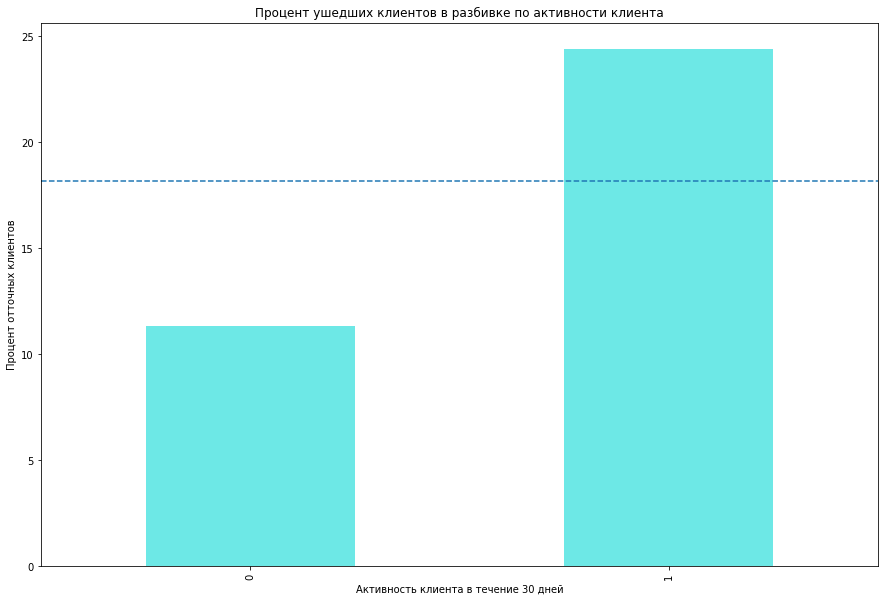

In [41]:
last_activity_churn['perc'].plot (kind = 'bar', figsize = (15,10), color = '#6de8e6')
plt.title ('Процент ушедших клиентов в разбивке по активности клиента') 
plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
plt.xlabel ('Активность клиента в течение 30 дней')
plt.ylabel ('Процент отточных клиентов')
plt.show ()

Вывод: отток клиентов, которые были активны в течении 30 дней, в 2 раза больше, чем неактивных.

**Составление портрета уходящих клиентов**

После анализа в разрезе парамтеров, можно составить портерт уходящего клиента:
- пол: мужской;
- возраст: от 26 до 62;
- город: не имеет значение;
- скоринговый балл: больше 800;
- оценка собственности (балл): выше 5 баллов;
- количество продуктов: больше 3;
- наличие кредитной карты: нет;
- последняя активность: да.

Выгрузим данные о таких пользователях.

In [42]:
portrait_churn = data.query ('male == 1 and equity >= 5 and score >= 800 and credit_card == 0 and last_activity == 1 and age > 26 \
    and age <= 62 and products >= 3 and churn == 1')
portrait_churn

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,...,city_Rostov,city_Rybinsk,city_Yaroslavl,female,male,age_group,18-25,26-45,46-62,63+
72,156677,873,Ярославль,М,39.0,5,915959.85,3,0,1,...,0,0,1,0,1,26-45,0,1,0,0
81,223978,850,Рыбинск,М,34.0,5,351583.16,4,0,1,...,0,1,0,0,1,26-45,0,1,0,0
399,212030,867,Ярославль,М,59.0,5,851896.68,3,0,1,...,0,0,1,0,1,46-62,0,0,1,0
475,140383,908,Ярославль,М,33.0,5,649294.72,4,0,1,...,0,0,1,0,1,26-45,0,1,0,0
734,170176,893,Ярославль,М,27.0,5,499315.41,3,0,1,...,0,0,1,0,1,26-45,0,1,0,0
1147,226891,864,Ярославль,М,39.0,5,920418.77,3,0,1,...,0,0,1,0,1,26-45,0,1,0,0
1204,223416,901,Ярославль,М,27.0,5,1007657.77,3,0,1,...,0,0,1,0,1,26-45,0,1,0,0
1292,131565,826,Ярославль,М,60.0,5,737821.34,3,0,1,...,0,0,1,0,1,46-62,0,0,1,0
1365,216512,918,Ярославль,М,34.0,5,1297184.34,3,0,1,...,0,0,1,0,1,26-45,0,1,0,0
1420,220656,899,Ярославль,М,59.0,5,1682723.25,3,0,1,...,0,0,1,0,1,46-62,0,0,1,0


Посмотрим теперь на портрет клиентов банка.

26-45    6074
46-62    2744
63+       779
18-25     376
Name: age_group, dtype: int64

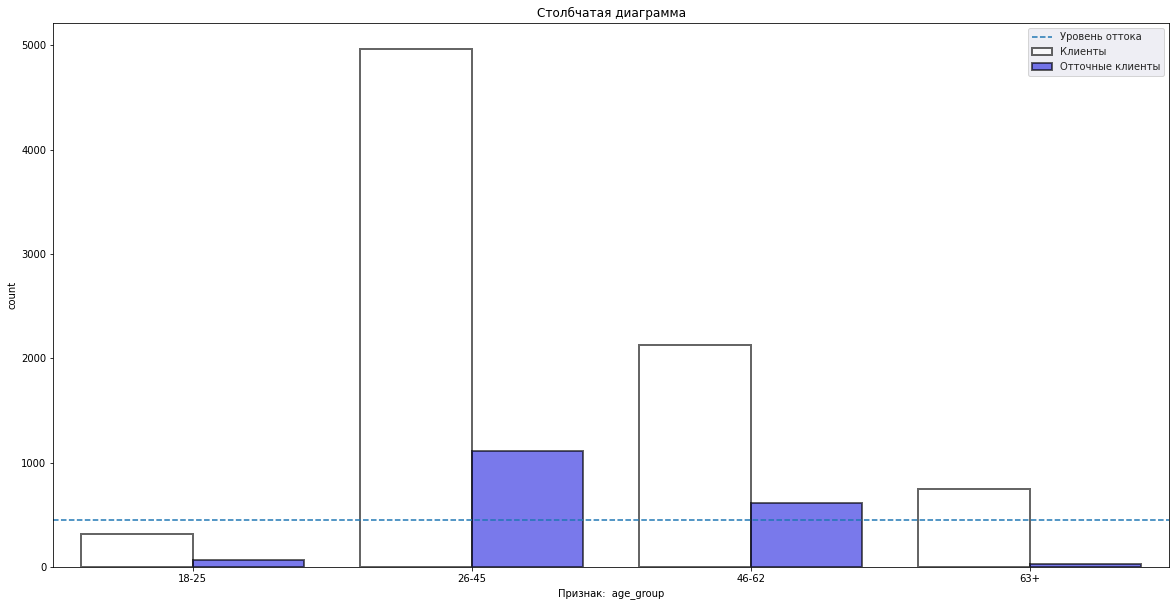

Ярославль    5888
Рыбинск      2694
Ростов       1417
Name: city, dtype: int64

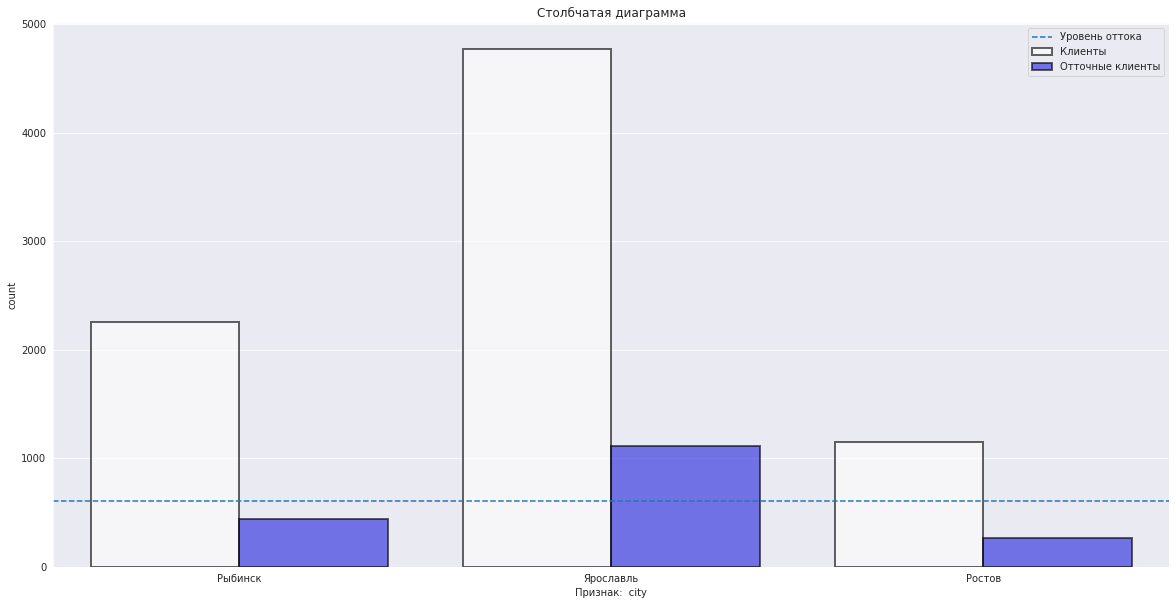

М    5005
Ж    4994
Name: gender, dtype: int64

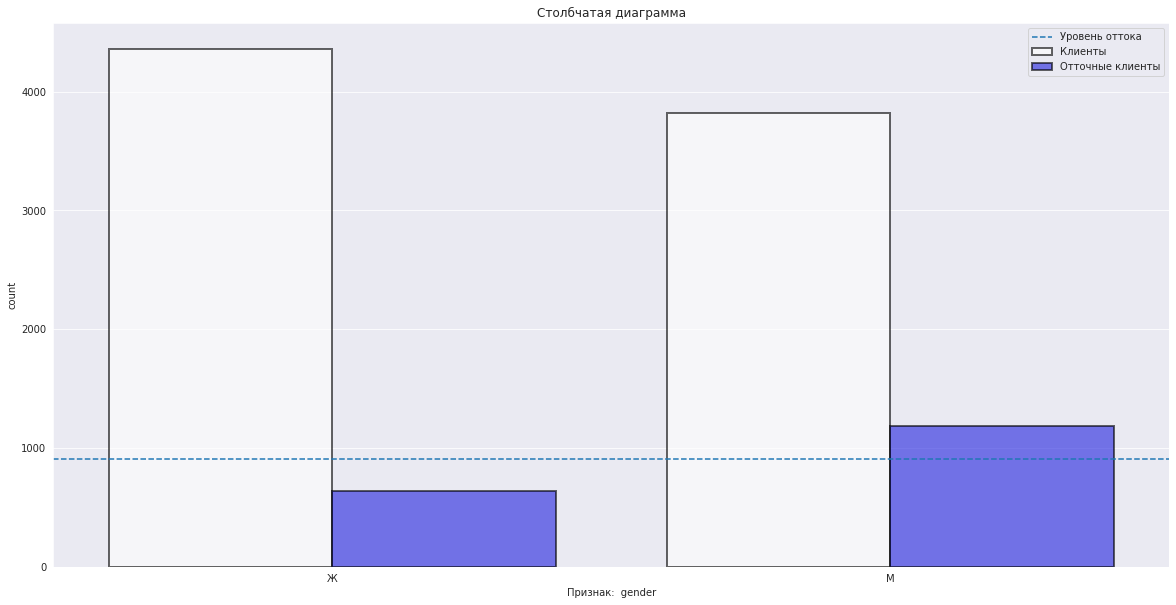

0    2592
5    1918
4    1850
3    1542
2    1052
1     774
6     161
7      80
8      17
9      13
Name: equity, dtype: int64

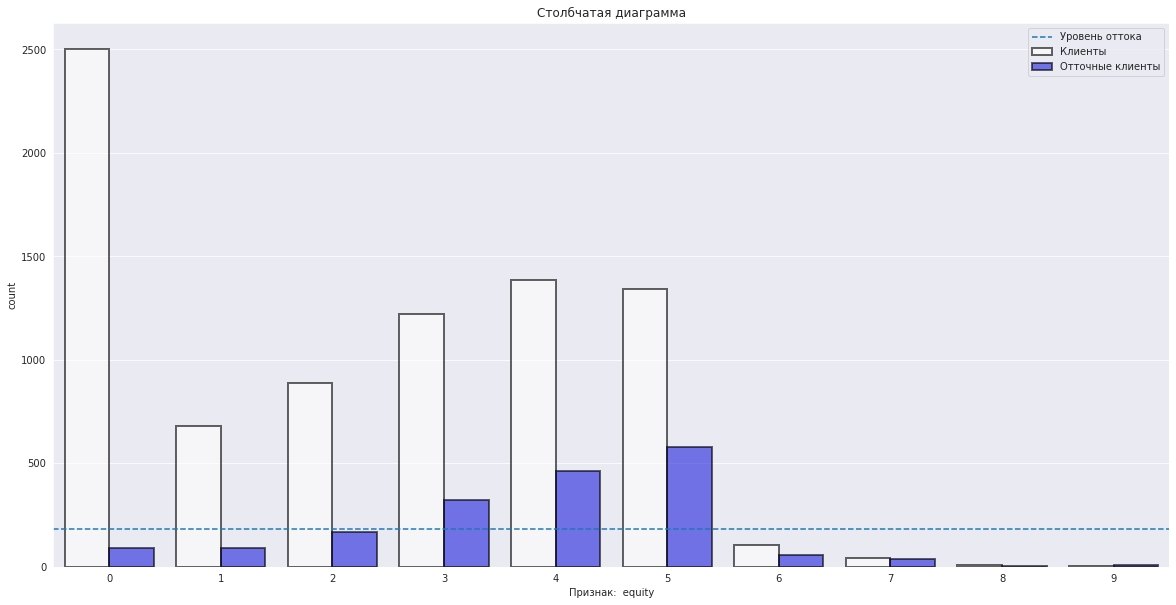

2    5126
1    3341
3    1039
4     474
5      19
Name: products, dtype: int64

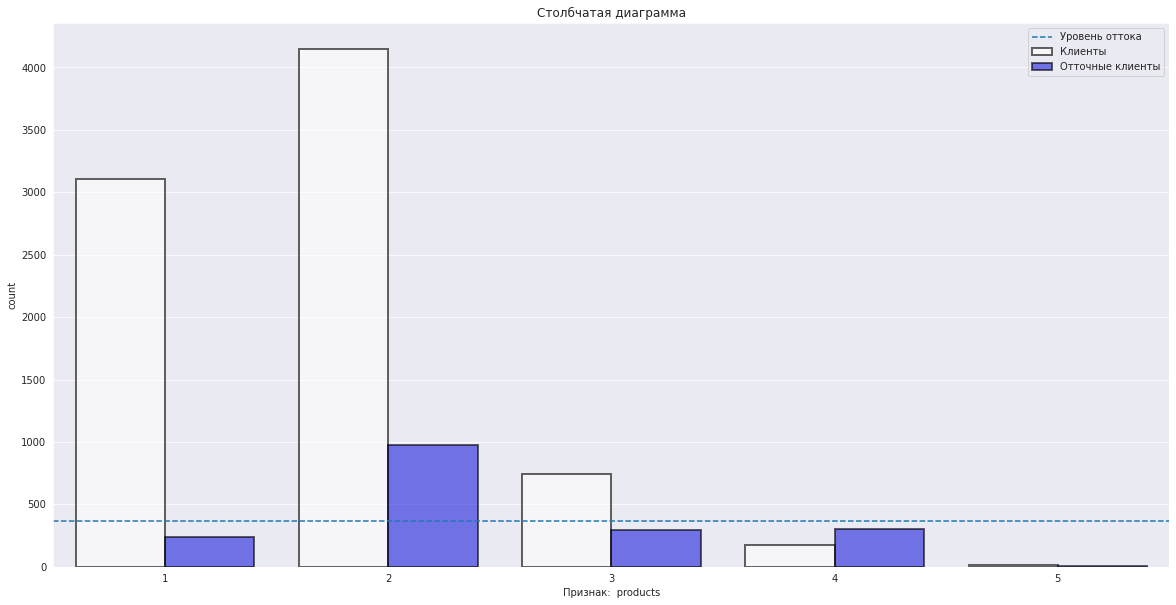

1    6804
0    3195
Name: credit_card, dtype: int64

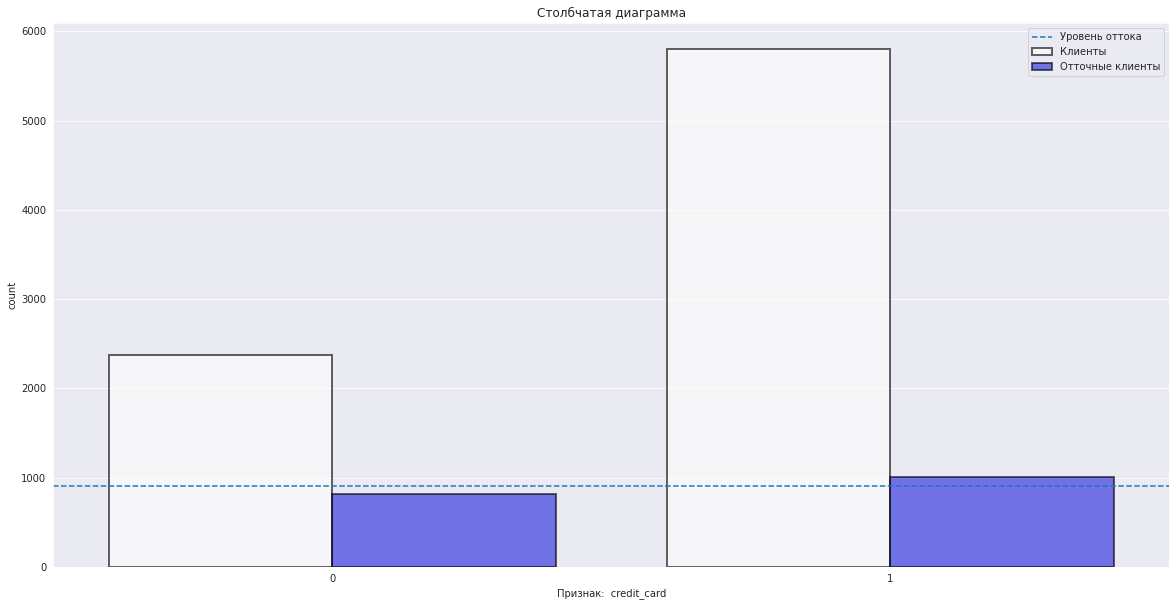

1    5235
0    4764
Name: last_activity, dtype: int64

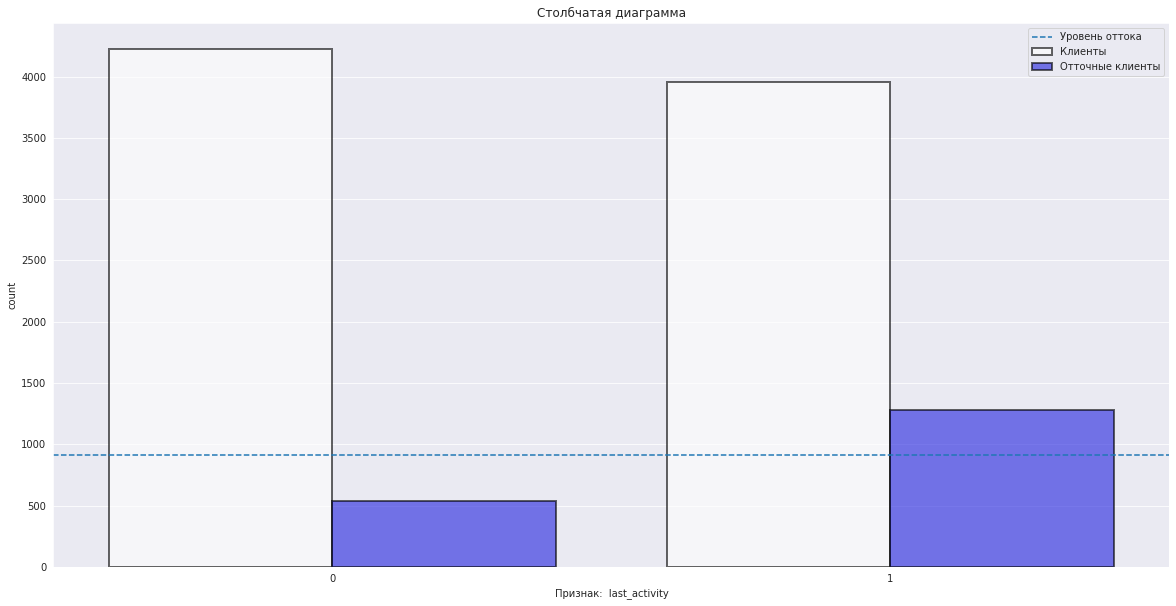

In [43]:
for column in ['age_group', 'city', 'gender', 'equity', 'products', 'credit_card', 'last_activity']:
    churn_rate = int((data.query('churn == 1').groupby(column).agg({'churn':'count'})).mean())
    
    plt.figure(figsize=(20,10))
    sns.countplot(data=data, x=column, hue='churn', alpha=0.6, edgecolor = 'black', linewidth=2, palette='flag', )
    sns.set_style('darkgrid')
    plt.axhline(churn_rate, label='Уровень оттока', linestyle='--')
    plt.title(f'Столбчатая диаграмма')
    plt.xlabel(f'Признак:  {column}')
    plt.legend(labels=['Уровень оттока', 'Клиенты', 'Отточные клиенты'])
    display(data[column].value_counts().sort_values(ascending=False))
    plt.show()

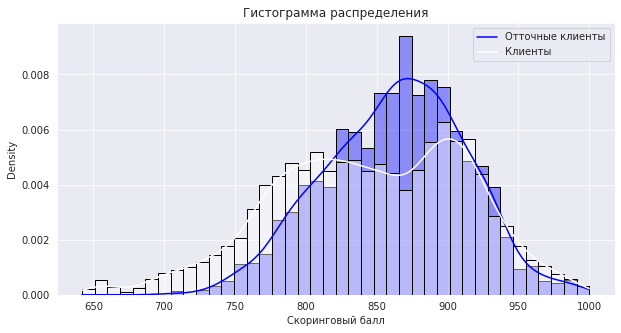

In [44]:
plt.figure(figsize=(10,5))
sns.histplot(data=data, x='score', hue='churn', edgecolor = 'black',  stat='density', common_norm=False, kde=True, alpha=0.4, palette='flag')
sns.set_style('darkgrid')
plt.title('Гистограмма распределения')
plt.xlabel('Скоринговый балл')
plt.legend(labels=['Отточные клиенты', 'Клиенты'])
plt.show()

Вывод по портрету клиентов банка:
- большая часть клиентов из Яровлавля;
- больше всего клиентов возраста от 26 до 45;
- клиентов женского пола незначительно больше, чем мужского;
- больше всего клиентов с оценков собственности 0;
- в основном у клиентов 1-2 продукта;
- у больше части клиентов есть кредитная карта;
- соотношение активности и неактивности клиентов примерно одинаково.

**Портрет клинета банка:**
- пол: любой;
- город: Ярославль;
- возраст: от 26 до 45;
- оценка собственности: 0;
- количество продуктов: 1-2;
- наличие кредитной карты: да;
- последняя активность: не имеет значение.

Относительно сравнительного анализа с оставшимися клиентами, можно сформировать **второй прортер** отточных клиентов:

**Портрет уходящего клинета банка:**
- пол: мужской;
- город: Ярославль;
- возраст: от 26 до 45;
- скоринговый балл: 820-940;
- оценка собственности: 3-5;
- количество продуктов: 2;
- наличие кредитной карты: да;
- последняя активность: да.

**Корреляционный анализ**

<AxesSubplot:>

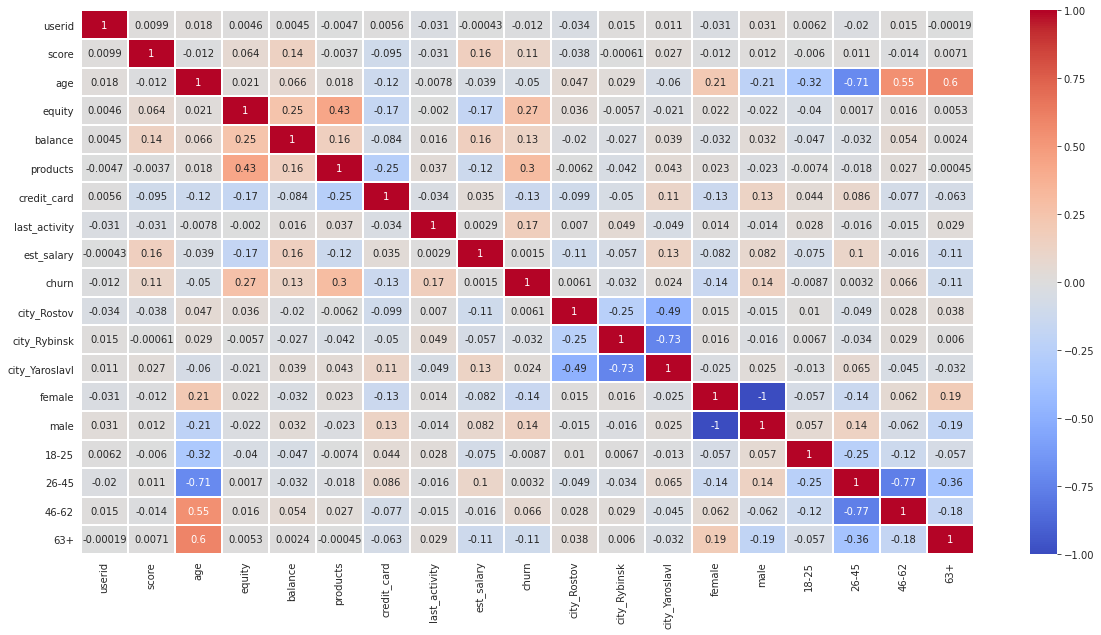

In [45]:
cor = data.drop(['userid'], axis=1).corr()
plt.figure (figsize = (20, 10))
sns.heatmap (data.corr(), annot = True, cmap = 'coolwarm', linewidths = 1)


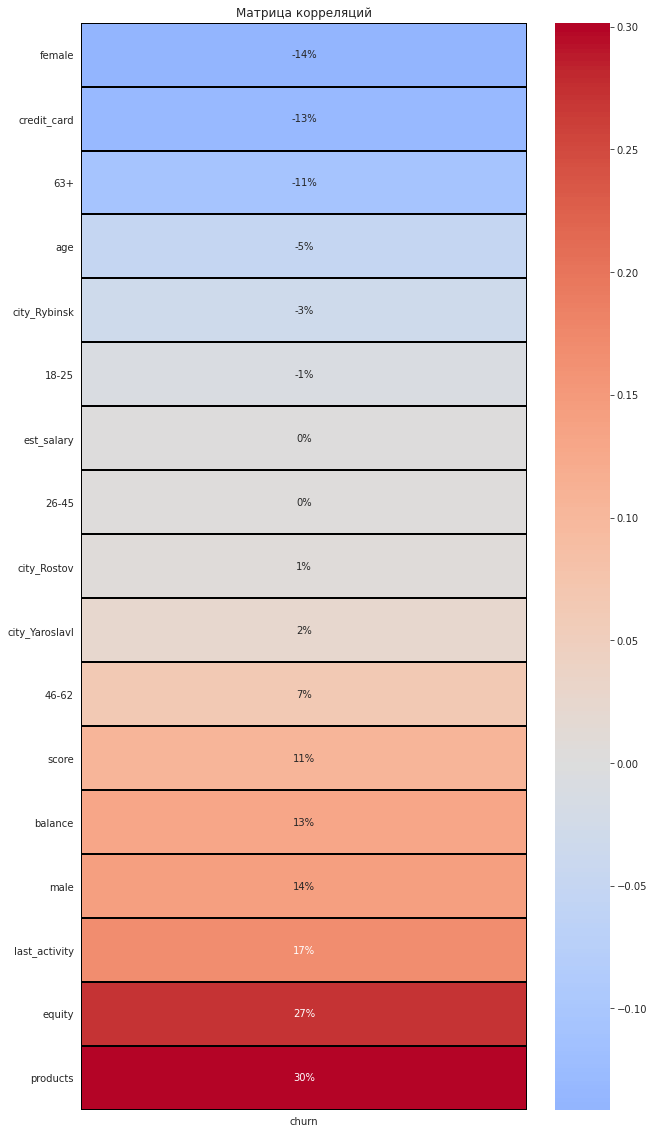

In [46]:
plt.figure(figsize=(10, 20))
sns.heatmap(cor.loc[:,['churn']].drop('churn').sort_values('churn'), annot=True, fmt='.0%', cmap='coolwarm',center=0, linecolor='black', linewidths=1)
plt.title('Матрица корреляций')
plt.show()

Вывод: 

На отток не влияют параметры:
- пол: женский;
- наличие кредитной карты;
- возраст: 63+;
- город: Рыбинск

На отток клиентов влияют параметры:
- количество банковских продуктов;
- количество баллов в собственности;
- активность в течение 30 дней;
- пол: мужской.

# Статистический анализ данных

**Гипотеза №1: различие доходов оставшихся и отточных клиентов**

**H0:** статистически значимых различий между средними доходами клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов нет.

**H1:** статистически значимых различий между средними доходами клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов есть.

Для проверки гипотезы проведем t-test:

In [47]:
# results = вызов метода для проверки гипотезы

results = st.ttest_ind (data[data['churn']==0]['est_salary'], data[data['churn']==1]['est_salary'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print ('Отвергаем гипотезу Н0')
else:
    print ('Принимаем гипотезу Н0')

0.8724727072323815
Принимаем гипотезу Н0


Вывод: при проведении статистичкого анализа, было выявлено, что статистически значимые различия между средними доходами клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов нет.

**Гипотеза №2: различие наличие кредитной карты у оставшихся и отточных клиентов**

**H0:** статистически значимых различий между клиентами с кредитной картой, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов нет.

**H1:** статистически значимых различий между клиентами с кредитной картой, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов есть.

Для проверки гипотезы проведем t-test:

In [48]:
# results = вызов метода для проверки гипотезы

results = st.ttest_ind (data[data['churn']==0]['credit_card'], data[data['churn']==1]['credit_card'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print ('Отвергаем гипотезу Н0.')
else:
    print ('Принимаем гипотезу Н0.')

1.929044005502269e-34
Отвергаем гипотезу Н0.


Вывод: при проведении статистичкого анализа, было выявлено, что статистически значимые различия между клинетами с кредитной картой, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов есть.

**Гипотеза №3: различие в количестве продуктов у оставшихся и отточных клиентов**

**H0:** статистически значимых различий между количеством продуктов клиентов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов нет. 

**H1:** статистически значимых различий между количеством продуктов клиентов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов есть.

Для проверки гипотезы проведем t-test:

In [49]:
# results = вызов метода для проверки гипотезы

results = st.ttest_ind (data[data['churn']==0]['products'], data[data['churn']==1]['products'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print ('Отвергаем гипотезу Н0')
else:
    print ('Принимаем гипотезу Н0')

3.241238337429691e-139
Отвергаем гипотезу Н0


Вывод: при проведении статистичкого анализа, было выявлено, что статистически значимые различия между количеством продуктов клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов есть.

# Промежуточные итоги

После **исследовательского анализа данных**, были определены портреты отточного клиента и клиента, который остался в банка.

**Портрет клинета банка:**
- пол: любой;
- город: Ярославль;
- возраст: от 26 до 45;
- оценка собственности: 0;
- количество продуктов: 1-2;
- наличие кредитной карты: да;
- последняя активность: не имеет значение.

**Портрет №1 уходящего клиента:**
- пол: мужской;
- возраст: от 26 до 62;
- город: не имеет значение;
- скоринговый балл: больше 800;
- оценка собственности (балл): выше 5 баллов;
- количество продуктов: больше 3;
- наличие кредитной карты: нет;
- последняя активность: да.

**Портрет №2 уходящего клинета банка:**
- пол: мужской;
- город: Ярославль;
- возраст: от 26 до 45;
- скоринговый балл: 820-940;
- оценка собственности: 3-5;
- количество продуктов: 2;
- наличие кредитной карты: да;
- последняя активность: да.

После **статистистечкого анализа**, в котором были проверены 3 гипотезы:
- различие средних доходов;
- различие наличия кредитной карты;
- различия в количестве банковских продуктов.

Для анализа были использован t-test, который показал, что:
-  при проведении статистичкого анализа, было выявлено, что статистически значимые различия между средними доходами клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов **нет**;
- при проведении статистичкого анализа, было выявлено, что статистически значимые различия между клинетами с кредитной картой, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов **есть**;
- при проведении статистичкого анализа, было выявлено, что статистически значимые различия между количеством продуктов клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов **есть**.

Далее разделим пользователей на сегменты и посмотрим на их сумму, количество и процент оттока.

# Сегментация пользователей

По итогам проведенного анализа и проверки гипотез выделим несколько сегментов пользователей.

В качестве криетриев обратим внимание на следующие параметры:

- возраст;
- город;
- количество обхектов собственности;
- количество банковских продуктов.

**Сегмент №1:**
- Пол: мужской
- Количество объектов собственности: более 3
- Количество используемых продуктов: более 3

Общее число пользователей в сегменте №1: 617
Число отточных пользователей в сегменте №1: 332
Доля отточных пользователей в сегменте №1: 53.80875202593193


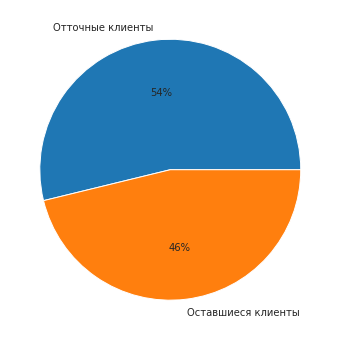

In [50]:
seg_1 = data.query ('male == 1 and equity >= 3 and products >= 3 ')['userid'].count()
seg_1_churn = data.query ('male == 1 and equity >= 3 and products >= 3 and churn == 1')['userid'].count()
seg_1_no_churn = data.query ('male == 1 and equity >= 3 and products >= 3 and churn == 0')['userid'].count()

seg_1_part = seg_1_churn / seg_1 * 100

# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №1:', seg_1 )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №1:', seg_1_churn)

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №1:', seg_1_part)

churn = [seg_1_churn, seg_1_no_churn]
labels = ['Отточные клиенты', 'Оставшиеся клиенты']

plt.figure(figsize=(6,6))
plt.pie(churn, labels = labels, autopct='%.0f%%')
plt.show()

**Сегмент №2:**
- Пол: мужской
- Город: Ярославль
- Количество используемных банковских продуктов: 2
- Активность в течение 30 дней: да

Общее число пользователей в сегменте №1: 509
Число отточных пользователей в сегменте №1: 215
Доля отточных пользователей в сегменте №1: 42.23968565815324


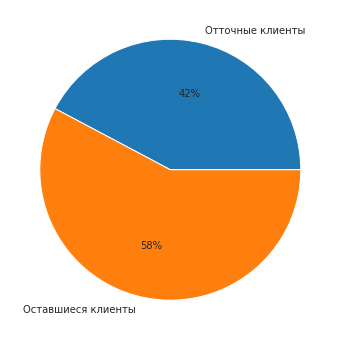

In [51]:
seg_2 = data.query ('male == 1 and city_Yaroslavl == 1 and equity >= 2 and products == 2 \
     and last_activity == 1')['userid'].count()
seg_2_churn = data.query ('male == 1 and city_Yaroslavl == 1 and equity >= 2 and products == 2 \
     and last_activity == 1 and churn == 1')['userid'].count()
seg_2_no_churn = data.query ('male == 1 and city_Yaroslavl == 1 and equity >= 2 and products == 2 \
     and last_activity == 1 and churn == 0')['userid'].count()

seg_2_part = seg_2_churn / seg_2 * 100

# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №1:', seg_2 )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №1:', seg_2_churn)

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №1:', seg_2_part)

churn = [seg_2_churn, seg_2_no_churn]
labels = ['Отточные клиенты', 'Оставшиеся клиенты']

plt.figure(figsize=(6,6))
plt.pie(churn, labels = labels, autopct='%.0f%%')
plt.show()

# Общие выводы

После **исследовательского анализа данных**, были определены пареметры, которые влияют на решение клиента об уходе:

- пол - мужщины покидают банка чаще женщин;
- возраст отточных клиентов - от 26 до 62;
- скорринговый балл - чем выше балл, тем чаще уходят;
- количество продукта - чем больше продуктов, тем чаще уходят;
- оценка собственности (балл) - чем выше балл, тем чаще уходят.

После **статистистечкого анализа**, в котором были проверены 3 гипотезы:
- различие средних доходов;
- различие наличия кредитной карты;
- различия в количестве банковских продуктов.

Для анализа были использован t-test, который показал, что:
-  при проведении статистичкого анализа, было выявлено, что статистически значимые различия между средними доходами клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов **нет**;
- при проведении статистичкого анализа, было выявлено, что статистически значимые различия между клинетами с кредитной картой, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов **есть**;
- при проведении статистичкого анализа, было выявлено, что статистически значимые различия между количеством продуктов клинетов, которые продолжаются пользоваться услугами и теми, кого отнесли к группе отточных клиентов **есть**.

По итогам проведенного анализа и проверки гипотез выделим несколько сегментов пользователей.

В качестве криетриев обратим внимание на следующие параметры:

- возраст;
- город;
- количество банковских продуктов;
- наличие кредитной карты.

**Рекоменадции для каждого сегмента**:

**Сегмент №1:**
Процент оттока данного сегмента: **53,8%**

- Пол: мужской
- Количество объектов собственности: более 3
- Количество используемых продуктов: более 3

Рекомендации:
- предложить оформить крелитную карту;
- оповещать клиентов о новых продуктах;
- предложить кэшбэк на разные виды товаров и услуг; 
- предложить выгодные условия, если клиент захочет, чтобы ему перечисляли заработную плату на карту банка;
- усовершенствование сайта/приложения банка.


**Сегмент №2:**
Процент оттока данного сегмента: **42,23%**

- Пол: мужской
- Город: Ярославль
- Количество объектов собственности: более 2
- Количество используемных банковских продуктов: 2
- Активность в течение 30 дней: да

Рекомендации:
- оповещать клиентов о новых продуктах;
- предложить кэшбэк на разные виды товаров и услуг;
- предложить выгодные условия, если клиент захочет, чтобы ему перечисляли заработную плату на карту банка;
-  усовершенствование сайта/приложения банка.